# Produce some plots of importation probabilities

Use the analytical formulas from Wallinga and Scalia Tomba


In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from tqdm import tqdm

## Jacob

In [26]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew
    
    

In [27]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    def __init__(self, offspring):
        self.offspring = offspring
    def set_lifespans(self, omega):
        self.omega = omega
    def set_immigration(self, eta):
        
        self.eta = eta
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
        method = methodclass(set_odes)
        method.set_ic(u0=ics)
        R, t = method.solver(time_points=t)
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if isinstance(n0, float):
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if isinstance(u, float):
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = u@Omega(t) + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
        method = methodclass(set_mean_odes)
        method.set_ic(u0=ics)
        M, t = method.solver(time_points=t)
        return M
        

# Variants Paper

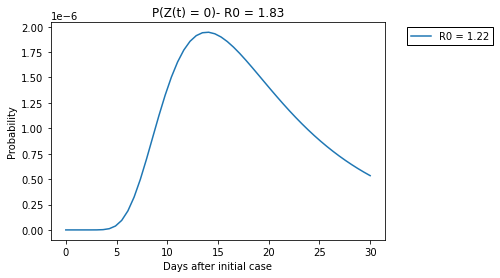

In [28]:
# Disease Parameters

Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype with roadmap changes
rtrans_variant = 1.5 # Relative transmissability of SA variant compared to wildtype
gamma = 0.4 # Recovery Rate
sigma = 0.3 # Progression rate from exposed to infectious
Reff = Reff_vec[0]

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
az_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to AstraZeneca vaccine
pfi_vac_uk = 1-0.7 # Reduction in transmission of UK variant due to Pfizer vaccine
new_vac_uk = 1-0.6 # Reduction in transmission of UK variant due to new vaccine
az_vac_sa = 1-0.1 # Reduction in transmission of SA variant due to AstraZeneca vaccine
pfi_vac_sa = 1-0.5 # Reduction in transmission of SA variant due to Pfizer vaccine
new_vac_sa = 1-0.9 # Reduction in transmission of SA variant due to new vaccine
vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

k = 1/10
time = np.linspace(0, 30)

ntypes = 16
nsus_trans = int(ntypes/2)
rho_mat = np.zeros((len(Reff_vec), len(time)))
# for r, Reff in enumerate(Reff_vec):
beta_SA = Reff*gamma*rtrans_variant
RV = Reff*rtrans_variant

# Probability of extinction with immigration

omega_infectious = beta_SA*np.ones(nsus_trans)
omega_infectious[1::2] *= sus_sa
for i in range(0, len(vaccine_vec)):
    omega_infectious[2*i:2*i+2]*= vaccine_vec[i]
omega_infectious += gamma
om_vec = np.append(sigma*np.ones(nsus_trans), omega_infectious)

def omega(t): # Return vector of lifetimes for each state
    return om_vec

beta_vec = beta_SA*np.ones(nsus_trans)
for i in range(0, len(vaccine_vec)):
    beta_vec[2*i:2*i+2]*= vaccine_vec[i]

def P(u, t):
    pvec = np.zeros_like(u)
    nexposed = int(ntypes/2)
    immunity_vec = np.ones(nexposed)
    immunity_vec[1::2]*= sus_sa
    for i in range(0, len(vaccine_vec)):
        immunity_vec[2*i:2*i+2]*= vaccine_vec[i]
    sum_gen_funcs = np.sum(immunity_vec*(1+(1/k)*(1-u[:nexposed]))**(-k))/nexposed
#     sum_gen_funcs = np.sum(immunity_vec*(u[:nexposed]))/nexposed

    for nex in range(0, nexposed):
        pvec[nex] = u[nex+nexposed] 
        pvec[nex+nexposed] = (beta_SA/(beta_SA + gamma)) * u[nex+nexposed] * sum_gen_funcs + (gamma/(beta_SA + gamma))
    return pvec
im_vec = np.zeros(ntypes)
im_vec[0] = 1/5
def eta(t):
    return im_vec.astype(float)
ics = np.zeros(ntypes+1)
ics[-1] = 1.
n0vec = np.ones(ntypes)
n0vec[-1] = 0


offspring = P
outbreak = MTBP_extinct(offspring)
outbreak.set_lifespans(omega)
outbreak.set_immigration(eta)
rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = False)
rho_mat[r, :] = rho[-1, :]

plt.plot(time, rho[-1, :], label = "R0 = " + str(Reff))

plt.title("P(Z(t) = 0)- R0 = " + str(RV))
plt.xlabel("Days after initial case")
plt.ylabel("Probability")
plt.savefig("./pnocases_R0=" + str(RV) + ".pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)

In [29]:
len(P(ics, 0))

17

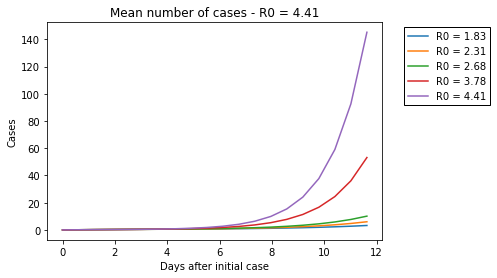

In [374]:
# Mean over time 


const_vec = np.array((1., sus_sa, az_vac_sa, az_vac_sa*sus_sa, pfi_vac_sa, pfi_vac_sa*sus_sa, new_vac_sa, new_vac_sa*sus_sa))
time = np.linspace(0, 30)

for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    def Omega(t):
        nexposed = int(ntypes/2)
        Omat = np.zeros((ntypes, ntypes))
        for nex in range(0, nexposed):
            Omat[nex, ntypes-nex-1] = 1
            Omat[nex+nexposed, :nexposed] = (const_vec[nex]/len(const_vec))*beta_SA/(beta_SA*gamma)
            Omat[nex+nexposed, nex+nexposed] = (np.sum(const_vec)/len(const_vec)) * beta_SA/(beta_SA + gamma)
        Omat -= np.identity(ntypes)
        Omat*= (beta_SA + gamma)
        return Omat
    outbreak.set_Omega(Omega)
    n0s = np.zeros(ntypes)
    Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)
    plt.plot(time[:20], np.sum(Mvec[:, :20]/(1-rho_mat[r, :20]), axis=0), label = 'R0 = ' + str(np.round(RV, 2)))
plt.title("Mean number of cases - R0 = " + str(RV))
plt.xlabel("Days after initial case")
plt.ylabel("Cases")
plt.savefig("./meancases_R0=" + str(RV) + ".pdf")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False)

In [64]:
import scipy.linalg as la
import numpy.linalg as nla

In [405]:
eigvls = nla.eig(Omega(0))[0]
eigvls = np.real_if_close(eigvls)
diagmat = np.diag(eigvls)
orth= np.real_if_close(nla.eig(Omega(0))[1])
H = np.kron(orth, np.kron(nla.inv(orth.conjugate()), nla.inv(orth.conjugate())))
Hinv = np.kron(nla.inv(orth), np.kron(orth.conjugate(), orth.conjugate()))

In [362]:
def H_mat(t):
    nexposed = int(ntypes/2)
    
    Gmat = np.zeros((ntypes, ntypes, ntypes))
    for level in range(0, nexposed):
        for i in range(0, nexposed):
            Gmat[level + nexposed, i, i] = 2 * (const_vec[i]/len(const_vec))*beta_SA/(beta_SA*gamma)
            Gmat[level + nexposed, i, level+nexposed] = (const_vec[i]/len(const_vec))*beta_SA/(beta_SA*gamma)
            Gmat[level + nexposed, level+nexposed, :nexposed] = (const_vec[i]/len(const_vec))*beta_SA/(beta_SA*gamma)
#             Gmat[level + nexposed, nexposed:, i+nexposed] = (const_vec[i]/len(const_vec))*beta_SA/(beta_SA*gamma)
    return Gmat
def P_vecs(t):
    nexposed = int(ntypes/2)
    Pmat = np.zeros((ntypes, ntypes))
    
    for i in range(0, nexposed):
        Pmat[i+nexposed, i] = (const_vec[i]/len(const_vec))*beta_SA/(beta_SA*gamma)
        Pmat[:nexposed, i+nexposed] = (const_vec[i]/len(const_vec))*beta_SA/(beta_SA*gamma)
        Pmat[i+nexposed, i+nexposed] = (np.sum(const_vec)/len(const_vec))*beta_SA/(beta_SA*gamma)
    return Pmat

In [363]:
Gmat = np.zeros((ntypes, ntypes, ntypes))
for l in range(0, ntypes):
    Gmat[l, :, :] = H_mat(0)[l, :, :] + np.diag(P_vecs(0)[:, l]) - np.outer(P_vecs(0)[:, l], P_vecs(0)[:, l])
    
    unitvec = np.zeros(ntypes)
    unitvec[l] = 1
    Gmat[l, :, :]+= np.outer(unitvec, unitvec) + np.outer(P_vecs(0)[:, l], P_vecs(0)[:, l]) - np.outer(unitvec, P_vecs(0)[:, l]) - np.outer(P_vecs(0)[:, l], unitvec)
    
    
    Gmat[l, :, :]*= (beta_SA + gamma)

In [423]:
C = np.hstack(np.hstack(Gmat))
def Deltamat(t):
    Delta = np.zeros(ntypes**3)
    eigs = eigvls.copy()
    for l in range(0, ntypes):
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[n + ntypes*(j + ntypes*l)] = (1/(eigs[l] - (eigs[j] + eigs[n])))*(np.exp(eigs[l]*t) - np.exp((eigs[j] + eigs[n])*t))
 
                 
    Deltamat = np.diag(Delta)
    
    return Deltamat

def Deltablarg(t):
    Delta = np.zeros(ntypes**3)
    eigs = eigvls.copy()
    for l in range(0, ntypes):
        for j in range(0, ntypes):
            for n in range(0, ntypes):
                Delta[l + ntypes*(j*ntypes + n)] = (1/(eigs[l] - (eigs[j] + eigs[n])))*(np.exp(eigs[l]*t) - np.exp((eigs[j] + eigs[n])*t))
                
    Deltamat = np.diag(Delta)
    return Deltamat

In [424]:
def vecvar(t):
    return H @ Deltamat(t) @ Hinv @ C

In [426]:
np.min(vecvar(10))

(-284041.1767555777+671.373421770111j)

In [422]:
Deltamat(1)[1][-1]

[4095, 15, 15, 15]

In [441]:
unitvec = np.zeros(ntypes)
unitvec[0] = 1
Psssss = P_vecs(0)[:, l]
banana = (H_mat(0)[0, :, :]+ np.diag(P_vecs(0)[:, 0]) + np.outer(unitvec, unitvec) + np.outer(Psssss, Psssss) - np.outer(unitvec, Psssss) - np.outer(Psssss, unitvec))*(beta_SA + gamma)
np.transpose(banana) - Gmat[0, :, :]


array([[-8.03892188e-02, -3.98142187e-02, -3.98142187e-02,
        -3.98142187e-02, -3.98142187e-02, -3.98142187e-02,
        -3.98142187e-02, -3.98142187e-02,  6.76250000e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.65428125e+00],
       [-3.98142187e-02,  7.60781250e-04,  7.60781250e-04,
         7.60781250e-04,  7.60781250e-04,  7.60781250e-04,
         7.60781250e-04,  7.60781250e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.07187500e-02],
       [-3.98142187e-02,  7.60781250e-04,  7.60781250e-04,
         7.60781250e-04,  7.60781250e-04,  7.60781250e-04,
         7.60781250e-04,  7.60781250e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.07187500e-02],
       [-3.98142187e-02,  7.60781250e

In [434]:
C

array([ 2.164,  0.   ,  0.   , ...,  0.   ,  0.   , -0.541])